In [1]:
import os
import string
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from collections import Counter


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        for param in resnet.parameters(): # freezing weights of resNet encoder
            param.requires_grad_(False)
        modules = list(resnet.children())[:-1]  # remove final fc layer
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.fc(features))
        return features


In [3]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions[:, :-1]))
        inputs = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(inputs)
        outputs = self.linear(hiddens)
        return outputs

    def sample(self, features, max_len=20):
        output_ids = []
        states = None
        inputs = features.unsqueeze(1)
        for _ in range(max_len):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            predicted = outputs.argmax(1)
            output_ids.append(predicted.item())
            inputs = self.embed(predicted).unsqueeze(1)
        return output_ids


In [4]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions, vocab, transform=None):
        self.root_dir = root_dir
        self.captions = captions  # list of (image_name, caption)
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        img_name, caption = self.captions[idx]
        image = Image.open(os.path.join(self.root_dir, img_name)).convert("RGB")
        if self.transform:
            image = self.transform(image)

        numerical_caption = [self.vocab["<start>"]] + \
            [self.vocab.get(word, self.vocab["<unk>"]) for word in caption.split()] + \
            [self.vocab["<end>"]]

        return image, torch.tensor(numerical_caption)


In [5]:
def build_vocab(captions_list, freq_threshold=5):
    counter = Counter()
    for _, caption in captions_list:
        counter.update(caption.split())

    words = [w for w, c in counter.items() if c >= freq_threshold]
    vocab = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
    for idx, word in enumerate(words, 4):
        vocab[word] = idx
    return vocab


In [6]:
import csv
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

if __name__ == "__main__":
    # === Load captions file ===
    captions_list = []
    with open("data/captions.txt", "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            img = row["image"].strip()
            caption = row["caption"].strip().lower()
            captions_list.append((img, caption))
    print(len(captions_list))
    
    # === Build vocabulary ===
    vocab = build_vocab(captions_list)
    vocab_size = len(vocab)
    print(f"✅ Vocabulary size: {vocab_size}")
    
    # === Dataset & Dataloader ===
    dataset = FlickrDataset(
        root_dir="data/images/",
        captions=captions_list,
        vocab=vocab,
        transform=transform
    )
    
    def collate_fn(batch):
        images = torch.stack([img for img, _ in batch])
        captions = [cap for _, cap in batch]
        captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True)
        return images, captions
    
    # Maximize single GPU utilization
    dataloader = DataLoader(
        dataset, 
        batch_size=128,  # Increase batch size (adjust based on GPU memory)
        shuffle=True, 
        collate_fn=collate_fn,
        num_workers=8,  # Parallel data loading to keep GPU fed
        pin_memory=True,  # Faster CPU-to-GPU transfer
        prefetch_factor=4,  # Prefetch batches ahead
        persistent_workers=True  # Keep workers alive between epochs
    )
    
    # === Device Setup - Single GPU ===
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print(f"Using device: {device}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    
    # === Models ===
    embed_size = 256
    hidden_size = 512
    lstm_layers = 2
    
    encoder = EncoderCNN(embed_size).to(device)
    decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=lstm_layers).to(device)
    
    # === Loss & Optimizer ===
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    params = list(decoder.parameters()) + list(encoder.fc.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=1e-3)
    
    # Mixed precision training for better GPU utilization
    scaler = GradScaler()
    
    # === Training Loop ===
    num_epochs = 15
    torch.backends.cudnn.benchmark = True  # Optimize cudnn operations
    
    for epoch in range(num_epochs):
        decoder.train()
        encoder.train()
        total_loss = 0
        
        for batch_idx, (images, captions) in enumerate(dataloader):
            images = images.to(device, non_blocking=True)
            captions = captions.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
            
            # Mixed precision training
            with autocast():
                features = encoder(images)
                outputs = decoder(features, captions[:, :-1])
                targets = captions[:, 1:]
                loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
            
            # Scaled backpropagation
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            
            # Optional: Print progress
            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(dataloader)}] Loss: {loss.item():.4f}")
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}] Avg Loss: {avg_loss:.4f}")
    
    # === Save Models ===
    torch.save({
        "encoder": encoder.state_dict(),
        "decoder": decoder.state_dict(),
        "vocab": vocab
    }, "caption_model_lstm2.pth")
    print("✅ Training complete. Model saved as caption_model.pth.")

40455
✅ Vocabulary size: 3005
Using device: cuda:0
GPU: NVIDIA RTX 6000 Ada Generation


/tmp/ipykernel_363080/929325483.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_363080/929325483.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/15] Batch [10/317] Loss: 5.6302
Epoch [1/15] Batch [20/317] Loss: 5.2904
Epoch [1/15] Batch [30/317] Loss: 5.0573
Epoch [1/15] Batch [40/317] Loss: 4.8645
Epoch [1/15] Batch [50/317] Loss: 4.6145
Epoch [1/15] Batch [60/317] Loss: 4.5561
Epoch [1/15] Batch [70/317] Loss: 4.3211
Epoch [1/15] Batch [80/317] Loss: 4.4711
Epoch [1/15] Batch [90/317] Loss: 4.2755
Epoch [1/15] Batch [100/317] Loss: 4.3470
Epoch [1/15] Batch [110/317] Loss: 4.2722
Epoch [1/15] Batch [120/317] Loss: 4.0635
Epoch [1/15] Batch [130/317] Loss: 4.2467
Epoch [1/15] Batch [140/317] Loss: 4.0764
Epoch [1/15] Batch [150/317] Loss: 4.2352
Epoch [1/15] Batch [160/317] Loss: 4.1602
Epoch [1/15] Batch [170/317] Loss: 4.0215
Epoch [1/15] Batch [180/317] Loss: 3.9877
Epoch [1/15] Batch [190/317] Loss: 4.1251
Epoch [1/15] Batch [200/317] Loss: 4.0944
Epoch [1/15] Batch [210/317] Loss: 3.9330
Epoch [1/15] Batch [220/317] Loss: 3.9774
Epoch [1/15] Batch [230/317] Loss: 3.9579
Epoch [1/15] Batch [240/317] Loss: 3.9800
E

In [7]:
# plotting loss after

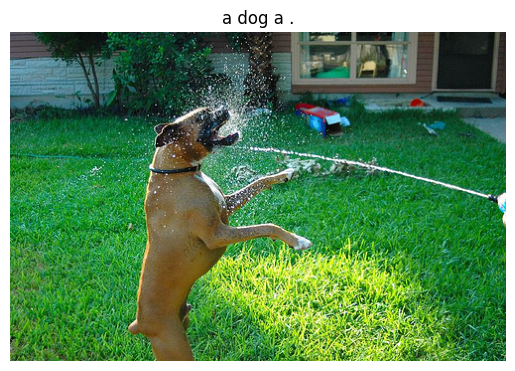

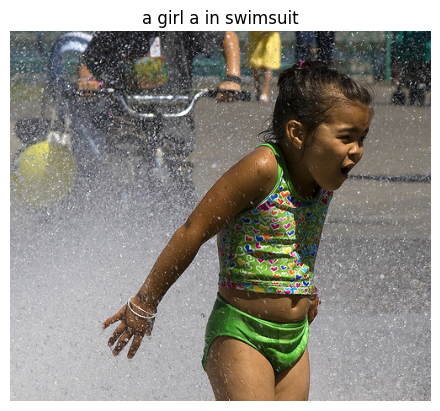

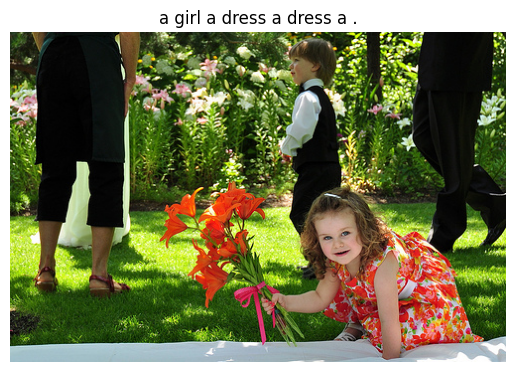

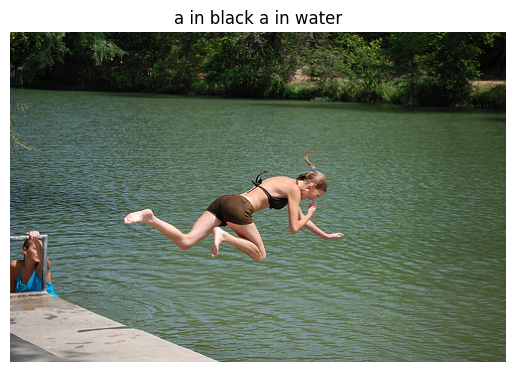

In [7]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

# === Load checkpoint ===
checkpoint = torch.load("caption_model.pth", map_location=device)
encoder.load_state_dict(checkpoint["encoder"])
decoder.load_state_dict(checkpoint["decoder"])
vocab = checkpoint["vocab"]  # assuming vocab is a dict: word -> idx
idx2word = {idx: word for word, idx in vocab.items()}  # reverse lookup

encoder.eval()
decoder.eval()

# === Caption generation function ===
def generate_caption(image, encoder, decoder, idx2word, max_len=20):
    with torch.no_grad():
        features = encoder(image.unsqueeze(0).to(device))
        output_ids = decoder.sample(features, max_len)
        # convert ids to words, stop at <end> token
        caption_words = []
        for idx in output_ids:
            word = idx2word[idx]
            if word == "<end>":
                break
            if word != "<start>":  # skip <start> token
                caption_words.append(word)
        caption = " ".join(caption_words)
        return caption

# === Define transform for test images ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

# === Visualize a few test images ===
test_images = ["data/images/44856031_0d82c2c7d1.jpg", "data/images/3765374230_cb1bbee0cb.jpg", "data/images/3760400645_3ba51d27f9.jpg", "data/images/3758787457_1a903ee1e9.jpg"]

for img_path in test_images:
    image = Image.open(img_path).convert("RGB")
    input_image = transform(image)
    caption = generate_caption(input_image, encoder, decoder, idx2word)

    plt.imshow(image)
    plt.axis("off")
    plt.title(caption)
    plt.show()


In [10]:
import csv
import numpy as np
from collections import defaultdict
import sacrebleu
from bert_score import score as bert_score
import torch
from PIL import Image
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. Charger le modèle pour la génération
checkpoint = torch.load("caption_model.pth", map_location=device)
vocab = checkpoint["vocab"]
vocab_size = len(vocab)
idx2word = {idx: word for word, idx in vocab.items()}

embed_size = 256
hidden_size = 512
lstm_layers = 1

# Initialize models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=lstm_layers).to(device)

encoder.load_state_dict(checkpoint["encoder"])
decoder.load_state_dict(checkpoint["decoder"])

encoder.eval()
decoder.eval()

print("✅ Modèle chargé pour l'évaluation")

# 2. Charger toutes les captions de référence par image
image_captions = defaultdict(list)
with open("data/captions.txt", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        img = row["image"].strip()
        caption = row["caption"].strip().lower()
        image_captions[img].append(caption)

print(f"✅ {len(image_captions)} images avec leurs captions de référence chargées")

# 3. Fonction de génération de caption
def generate_caption(image_path, encoder, decoder, idx2word, transform, max_len=20):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = encoder(image_tensor)
        output_ids = decoder.sample(features, max_len)
        
    caption_words = []
    for idx in output_ids:
        word = idx2word.get(idx, "<unk>")
        if word == "<end>":
            break
        if word not in ["<start>", "<pad>"]:
            caption_words.append(word)
    
    return " ".join(caption_words)

# 4. Évaluation sur un échantillon d'images
transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

# Prendre un échantillon d'images (par exemple 100)
sample_images = list(image_captions.keys())[:100]

# Storage for all generated and reference captions
all_generated = []
all_references = []  # List of lists (multiple references per image)

print("\n📊 Début de l'évaluation...")

# Generate all captions first
for idx, img_name in enumerate(sample_images, 1):
    img_path = f"data/images/{img_name}"
    
    # Générer la caption
    generated_caption = generate_caption(img_path, encoder, decoder, idx2word, transform_eval)
    
    # Références (toutes les captions pour cette image)
    reference_captions = image_captions[img_name]
    
    all_generated.append(generated_caption)
    all_references.append(reference_captions)
    
    if idx % 10 == 0:
        print(f"✓ Généré {idx} captions...")

print("\n📈 Calcul des métriques...")

# === BLEU Scores (1-4) using sacrebleu ===
# For BLEU, we need to format references properly
# sacrebleu expects: hypotheses as list, references as list of lists (transposed)
refs_transposed = [[refs[i] if i < len(refs) else refs[0] 
                    for refs in all_references] 
                   for i in range(max(len(refs) for refs in all_references))]

bleu1 = sacrebleu.corpus_bleu(all_generated, refs_transposed, force=True, lowercase=True)
bleu2 = sacrebleu.corpus_bleu(all_generated, refs_transposed, force=True, lowercase=True, max_ngram_order=2)
bleu3 = sacrebleu.corpus_bleu(all_generated, refs_transposed, force=True, lowercase=True, max_ngram_order=3)
bleu4 = sacrebleu.corpus_bleu(all_generated, refs_transposed, force=True, lowercase=True, max_ngram_order=4)

# === BERTScore ===
# Flatten references for BERTScore (it will compare each generated with all its references)
flat_generated = []
flat_references = []
for gen, refs in zip(all_generated, all_references):
    for ref in refs:
        flat_generated.append(gen)
        flat_references.append(ref)

print("   Calcul de BERTScore (peut prendre quelques minutes)...")
P, R, F1 = bert_score(flat_generated, flat_references, lang="en", verbose=False, device=device)

# Average BERTScore per image (group back by number of references)
bertscore_f1_per_image = []
bertscore_precision_per_image = []
bertscore_recall_per_image = []

start_idx = 0
for refs in all_references:
    num_refs = len(refs)
    end_idx = start_idx + num_refs
    
    bertscore_f1_per_image.append(F1[start_idx:end_idx].mean().item())
    bertscore_precision_per_image.append(P[start_idx:end_idx].mean().item())
    bertscore_recall_per_image.append(R[start_idx:end_idx].mean().item())
    
    start_idx = end_idx

# 5. Résultats finaux
print("\n" + "="*60)
print("📈 RÉSULTATS D'ÉVALUATION")
print("="*60)

print(f"\n🔹 BLEU Scores:")
print(f"   BLEU-1: {bleu1.score:.2f}")
print(f"   BLEU-2: {bleu2.score:.2f}")
print(f"   BLEU-3: {bleu3.score:.2f}")
print(f"   BLEU-4: {bleu4.score:.2f}")

print(f"\n🔹 BERTScore (moyenne sur {len(sample_images)} images):")
print(f"   F1        : {np.mean(bertscore_f1_per_image):.4f} (±{np.std(bertscore_f1_per_image):.4f})")
print(f"   Precision : {np.mean(bertscore_precision_per_image):.4f} (±{np.std(bertscore_precision_per_image):.4f})")
print(f"   Recall    : {np.mean(bertscore_recall_per_image):.4f} (±{np.std(bertscore_recall_per_image):.4f})")

# 6. Exemple détaillé pour quelques images
print("\n" + "="*60)
print("📸 EXEMPLES DÉTAILLÉS")
print("="*60)

for i in range(min(3, len(sample_images))):
    example_img = sample_images[i]
    example_path = f"data/images/{example_img}"
    generated = all_generated[i]
    references = all_references[i]
    
    print(f"\n[Image {i+1}] {example_img}:")
    print(f"   Caption générée: '{generated}'")
    print(f"   Captions de référence:")
    for j, ref in enumerate(references, 1):
        print(f"      {j}. '{ref}'")
    
    # Individual BLEU-1 scores against each reference
    bleu1_individual = [sacrebleu.corpus_bleu([generated], [[ref]], 
                                              force=True, lowercase=True).score
                        for ref in references]
    print(f"   BLEU-1 par référence: {[f'{b:.2f}' for b in bleu1_individual]}")
    print(f"   BERTScore F1: {bertscore_f1_per_image[i]:.4f}")

print("\n✅ Évaluation terminée!")

# 7. Sauvegarder les résultats
import json
from datetime import datetime

# Prepare results dictionary
results = {
    "metadata": {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "num_images_evaluated": len(sample_images),
        "model_file": "caption_model.pth",
        "vocab_size": vocab_size
    },
    "bleu_scores": {
        "BLEU-1": float(bleu1.score),
        "BLEU-2": float(bleu2.score),
        "BLEU-3": float(bleu3.score),
        "BLEU-4": float(bleu4.score)
    },
    "bertscore": {
        "f1_mean": float(np.mean(bertscore_f1_per_image)),
        "f1_std": float(np.std(bertscore_f1_per_image)),
        "precision_mean": float(np.mean(bertscore_precision_per_image)),
        "precision_std": float(np.std(bertscore_precision_per_image)),
        "recall_mean": float(np.mean(bertscore_recall_per_image)),
        "recall_std": float(np.std(bertscore_recall_per_image))
    },
    "per_image_results": []
}

# Add per-image details
for i, img_name in enumerate(sample_images):
    img_result = {
        "image": img_name,
        "generated_caption": all_generated[i],
        "reference_captions": all_references[i],
        "bertscore_f1": float(bertscore_f1_per_image[i]),
        "bertscore_precision": float(bertscore_precision_per_image[i]),
        "bertscore_recall": float(bertscore_recall_per_image[i])
    }
    results["per_image_results"].append(img_result)

# Save to JSON
json_filename = f"evaluation_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(json_filename, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print(f"\n💾 Résultats sauvegardés dans: {json_filename}")

# Save summary to text file
txt_filename = f"evaluation_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
with open(txt_filename, "w", encoding="utf-8") as f:
    f.write("="*60 + "\n")
    f.write("📈 RÉSULTATS D'ÉVALUATION - RÉSUMÉ\n")
    f.write("="*60 + "\n")
    f.write(f"\nDate: {results['metadata']['timestamp']}\n")
    f.write(f"Nombre d'images évaluées: {results['metadata']['num_images_evaluated']}\n")
    f.write(f"Taille du vocabulaire: {results['metadata']['vocab_size']}\n")
    
    f.write(f"\n🔹 BLEU Scores:\n")
    f.write(f"   BLEU-1: {bleu1.score:.2f}\n")
    f.write(f"   BLEU-2: {bleu2.score:.2f}\n")
    f.write(f"   BLEU-3: {bleu3.score:.2f}\n")
    f.write(f"   BLEU-4: {bleu4.score:.2f}\n")
    
    f.write(f"\n🔹 BERTScore:\n")
    f.write(f"   F1        : {np.mean(bertscore_f1_per_image):.4f} (±{np.std(bertscore_f1_per_image):.4f})\n")
    f.write(f"   Precision : {np.mean(bertscore_precision_per_image):.4f} (±{np.std(bertscore_precision_per_image):.4f})\n")
    f.write(f"   Recall    : {np.mean(bertscore_recall_per_image):.4f} (±{np.std(bertscore_recall_per_image):.4f})\n")
    
    f.write("\n" + "="*60 + "\n")
    f.write("📸 EXEMPLES DÉTAILLÉS (3 premières images)\n")
    f.write("="*60 + "\n")
    
    for i in range(min(3, len(sample_images))):
        example_img = sample_images[i]
        generated = all_generated[i]
        references = all_references[i]
        
        f.write(f"\n[Image {i+1}] {example_img}:\n")
        f.write(f"   Caption générée: '{generated}'\n")
        f.write(f"   Captions de référence:\n")
        for j, ref in enumerate(references, 1):
            f.write(f"      {j}. '{ref}'\n")
        
        bleu1_individual = [sacrebleu.corpus_bleu([generated], [[ref]], 
                                                  force=True, lowercase=True).score
                            for ref in references]
        f.write(f"   BLEU-1 par référence: {[f'{b:.2f}' for b in bleu1_individual]}\n")
        f.write(f"   BERTScore F1: {bertscore_f1_per_image[i]:.4f}\n")

print(f"💾 Résumé sauvegardé dans: {txt_filename}")

# Save generated captions to CSV for easy analysis
csv_filename = f"generated_captions_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
with open(csv_filename, "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "generated_caption", "bertscore_f1", "bertscore_precision", "bertscore_recall"])
    
    for i, img_name in enumerate(sample_images):
        writer.writerow([
            img_name,
            all_generated[i],
            f"{bertscore_f1_per_image[i]:.4f}",
            f"{bertscore_precision_per_image[i]:.4f}",
            f"{bertscore_recall_per_image[i]:.4f}"
        ])

print(f"💾 Captions générées sauvegardées dans: {csv_filename}")
print("\n🎉 Toutes les sauvegardes terminées!")

ModuleNotFoundError: No module named 'sacrebleu'